# 01_segmentation_train_eval.ipynb

This file performs the model training process of our Pix2Pix-based lung segmentation system.
Additionally, it performs model evaluation based on a seperately defined test dataset.

### Part 1: Define directories, import required libraries and setup sesion

In [1]:
# Change working directory to the root folder
import os, sys
if os.path.split(os.getcwd())[-1] != 'SmartDetect_segmentation':
    %cd ..
    sys.path.append("src")
    
    if os.path.split(os.getcwd())[-1] != 'SmartDetect_segmentation':
        raise UserError("Something went wrong in the directory reassignment!")

D:\SmartDetect_segmentation


In [2]:
# Perform required imports
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import preprocessing
from dataset import generate_dataset
from model import define_discriminator, define_generator, define_gan
from training import *
from evaluation import *
from util.general import *
from util.inspection import *
from util.tf_session import *

# Setup GPU tensorflow session
n_gpus = setup_tf_gpu_session()

In [3]:
# Define some basic directories to use in the rest of this program
dataDir = os.path.join("data", "preprocessed")
modelDir = "model"
notebookDir = "notebook"
logDir = "logs"

### Part 2: Perform data preprocessing
Please note that since this part may take quite a long time, it is skipped on default if the software detects preprocessed data already.

In [4]:
# Preprocessing the data. 
# To rerun the preprocessing, change 'rerun' to True

preprocessing(rerun=False)

--- Performing data preprocessing --- 
Extracting data from:	D:\SmartDetect_segmentation\data\raw
Outputting data to:	D:\SmartDetect_segmentation\data\preprocessed

Extracting data from subset 'CXR_ChinaSet' (1/3)... 
(found 566 images)
 |##################################################| 100.0% 

Result: WARNING (Missed 96 mask files)

Extracting data from subset 'CXR_Manual  ' (2/3)... 
(found 171 images)
 |##################################################| 100.0% 

Result: OK

Extracting data from subset 'CXR_Mntg    ' (3/3)... 
(found 138 images)
 |##################################################| 100.0% 

Result: OK


### Part 3: Dataset generation
The data is split into a training and test set per default.
Validation is performed with the training set based on a later split.

In [5]:
dataset_train = generate_dataset(dataDir, split_dataset=True, train_or_test='train')
dataset_test = generate_dataset(dataDir, split_dataset=True, train_or_test='test')


--- Performing data extraction (train) ---

Extracting data from D:\SmartDetect_segmentation\data\preprocessed
 |##################################################| 100.0% 
Completed. Dataset consists of 701 images and is 0.74 GB

--- Performing data extraction (test) ---

Extracting data from D:\SmartDetect_segmentation\data\preprocessed
 |##################################################| 100.0% 
Completed. Dataset consists of 174 images and is 0.18 GB


##### Visual data inspection
Here, we will also briefly inspect the data we'll be training the model with.

--- Performing data inspection for dataset 'train' ---

Amount of subjects:	701
Image size:		256, 256


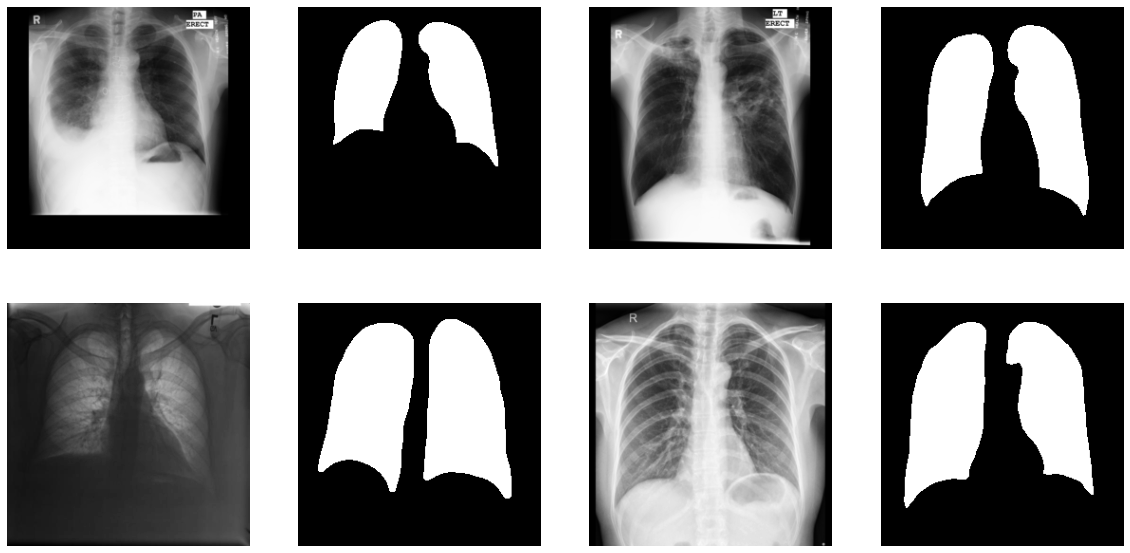



--- Performing data inspection for dataset 'test' ---

Amount of subjects:	174
Image size:		256, 256


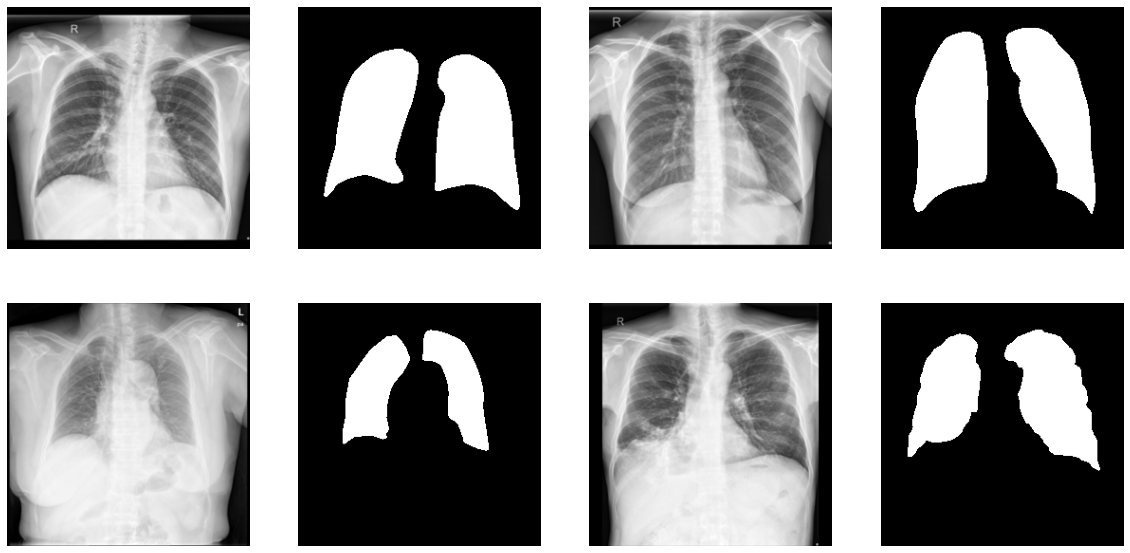

In [6]:
_, image_shape = inspect_dataset(dataset_train, 'train')
_, _ = inspect_dataset(dataset_test, 'test')

### Part 4: Model definition
Here, we will define the GAN model we'll be using for the segmentation purposes.
It is derived from the Pix2Pix model.

In [7]:
image_shape = (image_shape[0], image_shape[1], 1)

g_model = define_generator(image_shape)
d_model = define_discriminator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

### Part 5: Monitoring
The training process is monitored via TensorBoard.
The results will be displayed here by default. Note, however, that we may also monitor the process manually or after training time by opening tensorboard via the terminal as such:

`tensorboard --logdir "logs"`

In [8]:
# %load_ext tensorboard
# %tensorboard --logdir {logDir}

### Part 6: Training
Here, the actual training process is performed. 
We may pass some hyperparameters in the 'train' function.

In [9]:
_, last_save = train(d_model, g_model, gan_model, dataset_train) 


Epoch 1/1000:


100%|#########################################################################################################################################################################| 140/140 [00:48<00:00,  2.90it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000141.h5
>Validation MAE = 0.061903

Epoch 2/1000:


100%|#########################################################################################################################################################################| 140/140 [00:42<00:00,  3.30it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000281.h5
>Validation MAE = 0.054505

Epoch 3/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.40it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000421.h5
>Validation MAE = 0.045411

Epoch 4/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000561.h5
>Validation MAE = 0.062670

Epoch 5/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000701.h5
>Validation MAE = 0.041872

Epoch 6/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000841.h5
>Validation MAE = 0.031777

Epoch 7/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0000981.h5
>Validation MAE = 0.042347

Epoch 8/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001121.h5
>Validation MAE = 0.038191

Epoch 9/1000:


100%|#########################################################################################################################################################################| 140/140 [00:39<00:00,  3.53it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001261.h5
>Validation MAE = 0.053057

Epoch 10/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.38it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001401.h5
>Validation MAE = 0.038072

Epoch 11/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.42it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001541.h5
>Validation MAE = 0.041771

Epoch 12/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001681.h5
>Validation MAE = 0.034944

Epoch 13/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001821.h5
>Validation MAE = 0.042724

Epoch 14/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0001961.h5
>Validation MAE = 0.037937

Epoch 15/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002101.h5
>Validation MAE = 0.049002

Epoch 16/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002241.h5
>Validation MAE = 0.035049

Epoch 17/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002381.h5
>Validation MAE = 0.047985

Epoch 18/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002521.h5
>Validation MAE = 0.040650

Epoch 19/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002661.h5
>Validation MAE = 0.059782

Epoch 20/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002801.h5
>Validation MAE = 0.034182

Epoch 21/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0002941.h5
>Validation MAE = 0.043623

Epoch 22/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003081.h5
>Validation MAE = 0.034437

Epoch 23/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003221.h5
>Validation MAE = 0.033899

Epoch 24/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003361.h5
>Validation MAE = 0.034729

Epoch 25/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003501.h5
>Validation MAE = 0.036918

Epoch 26/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003641.h5
>Validation MAE = 0.038487

Epoch 27/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003781.h5
>Validation MAE = 0.049456

Epoch 28/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0003921.h5
>Validation MAE = 0.043585

Epoch 29/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004061.h5
>Validation MAE = 0.038155

Epoch 30/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004201.h5
>Validation MAE = 0.039225

Epoch 31/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004341.h5
>Validation MAE = 0.025941

Epoch 32/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004481.h5
>Validation MAE = 0.040278

Epoch 33/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004621.h5
>Validation MAE = 0.042082

Epoch 34/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004761.h5
>Validation MAE = 0.029401

Epoch 35/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0004901.h5
>Validation MAE = 0.046085

Epoch 36/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005041.h5
>Validation MAE = 0.031012

Epoch 37/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005181.h5
>Validation MAE = 0.042305

Epoch 38/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005321.h5
>Validation MAE = 0.038761

Epoch 39/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.37it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005461.h5
>Validation MAE = 0.029521

Epoch 40/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.37it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005601.h5
>Validation MAE = 0.033252

Epoch 41/1000:


100%|#########################################################################################################################################################################| 140/140 [00:42<00:00,  3.30it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005741.h5
>Validation MAE = 0.034261

Epoch 42/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.35it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0005881.h5
>Validation MAE = 0.019038

Epoch 43/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006021.h5
>Validation MAE = 0.034089

Epoch 44/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006161.h5
>Validation MAE = 0.036843

Epoch 45/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006301.h5
>Validation MAE = 0.029829

Epoch 46/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006441.h5
>Validation MAE = 0.051461

Epoch 47/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006581.h5
>Validation MAE = 0.041225

Epoch 48/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006721.h5
>Validation MAE = 0.025826

Epoch 49/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0006861.h5
>Validation MAE = 0.029755

Epoch 50/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007001.h5
>Validation MAE = 0.035758

Epoch 51/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007141.h5
>Validation MAE = 0.032291

Epoch 52/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007281.h5
>Validation MAE = 0.031993

Epoch 53/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007421.h5
>Validation MAE = 0.032896

Epoch 54/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007561.h5
>Validation MAE = 0.022658

Epoch 55/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007701.h5
>Validation MAE = 0.030182

Epoch 56/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007841.h5
>Validation MAE = 0.030963

Epoch 57/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0007981.h5
>Validation MAE = 0.038484

Epoch 58/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008121.h5
>Validation MAE = 0.026801

Epoch 59/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008261.h5
>Validation MAE = 0.036777

Epoch 60/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008401.h5
>Validation MAE = 0.038679

Epoch 61/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008541.h5
>Validation MAE = 0.037767

Epoch 62/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008681.h5
>Validation MAE = 0.036597

Epoch 63/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008821.h5
>Validation MAE = 0.039068

Epoch 64/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0008961.h5
>Validation MAE = 0.029959

Epoch 65/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009101.h5
>Validation MAE = 0.050045

Epoch 66/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009241.h5
>Validation MAE = 0.028730

Epoch 67/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009381.h5
>Validation MAE = 0.043562

Epoch 68/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009521.h5
>Validation MAE = 0.037048

Epoch 69/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009661.h5
>Validation MAE = 0.040017

Epoch 70/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009801.h5
>Validation MAE = 0.028023

Epoch 71/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0009941.h5
>Validation MAE = 0.026929

Epoch 72/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010081.h5
>Validation MAE = 0.030956

Epoch 73/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010221.h5
>Validation MAE = 0.035352

Epoch 74/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010361.h5
>Validation MAE = 0.034637

Epoch 75/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010501.h5
>Validation MAE = 0.039854

Epoch 76/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010641.h5
>Validation MAE = 0.044908

Epoch 77/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010781.h5
>Validation MAE = 0.042235

Epoch 78/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0010921.h5
>Validation MAE = 0.034590

Epoch 79/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011061.h5
>Validation MAE = 0.037319

Epoch 80/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011201.h5
>Validation MAE = 0.033130

Epoch 81/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011341.h5
>Validation MAE = 0.025495

Epoch 82/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011481.h5
>Validation MAE = 0.033263

Epoch 83/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011621.h5
>Validation MAE = 0.052628

Epoch 84/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011761.h5
>Validation MAE = 0.041199

Epoch 85/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0011901.h5
>Validation MAE = 0.036795

Epoch 86/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012041.h5
>Validation MAE = 0.032819

Epoch 87/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012181.h5
>Validation MAE = 0.035654

Epoch 88/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012321.h5
>Validation MAE = 0.024003

Epoch 89/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012461.h5
>Validation MAE = 0.030338

Epoch 90/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012601.h5
>Validation MAE = 0.035435

Epoch 91/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012741.h5
>Validation MAE = 0.044533

Epoch 92/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0012881.h5
>Validation MAE = 0.037755

Epoch 93/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013021.h5
>Validation MAE = 0.029175

Epoch 94/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013161.h5
>Validation MAE = 0.042196

Epoch 95/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013301.h5
>Validation MAE = 0.036562

Epoch 96/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013441.h5
>Validation MAE = 0.032232

Epoch 97/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013581.h5
>Validation MAE = 0.032832

Epoch 98/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013721.h5
>Validation MAE = 0.053793

Epoch 99/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0013861.h5
>Validation MAE = 0.033699

Epoch 100/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014001.h5
>Validation MAE = 0.053447

Epoch 101/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014141.h5
>Validation MAE = 0.031994

Epoch 102/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014281.h5
>Validation MAE = 0.031195

Epoch 103/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014421.h5
>Validation MAE = 0.038917

Epoch 104/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014561.h5
>Validation MAE = 0.054903

Epoch 105/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014701.h5
>Validation MAE = 0.037595

Epoch 106/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.37it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014841.h5
>Validation MAE = 0.036563

Epoch 107/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.35it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0014981.h5
>Validation MAE = 0.040273

Epoch 108/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.34it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015121.h5
>Validation MAE = 0.036550

Epoch 109/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.40it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015261.h5
>Validation MAE = 0.030358

Epoch 110/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015401.h5
>Validation MAE = 0.030473

Epoch 111/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015541.h5
>Validation MAE = 0.028572

Epoch 112/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015681.h5
>Validation MAE = 0.038072

Epoch 113/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015821.h5
>Validation MAE = 0.041727

Epoch 114/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0015961.h5
>Validation MAE = 0.027871

Epoch 115/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016101.h5
>Validation MAE = 0.031377

Epoch 116/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016241.h5
>Validation MAE = 0.036220

Epoch 117/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016381.h5
>Validation MAE = 0.045775

Epoch 118/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016521.h5
>Validation MAE = 0.043205

Epoch 119/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016661.h5
>Validation MAE = 0.031456

Epoch 120/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016801.h5
>Validation MAE = 0.030418

Epoch 121/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0016941.h5
>Validation MAE = 0.025396

Epoch 122/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017081.h5
>Validation MAE = 0.045557

Epoch 123/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017221.h5
>Validation MAE = 0.037663

Epoch 124/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017361.h5
>Validation MAE = 0.043420

Epoch 125/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017501.h5
>Validation MAE = 0.029071

Epoch 126/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017641.h5
>Validation MAE = 0.030444

Epoch 127/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017781.h5
>Validation MAE = 0.027486

Epoch 128/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0017921.h5
>Validation MAE = 0.047592

Epoch 129/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018061.h5
>Validation MAE = 0.025358

Epoch 130/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018201.h5
>Validation MAE = 0.045605

Epoch 131/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018341.h5
>Validation MAE = 0.030916

Epoch 132/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018481.h5
>Validation MAE = 0.038688

Epoch 133/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018621.h5
>Validation MAE = 0.028196

Epoch 134/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018761.h5
>Validation MAE = 0.027835

Epoch 135/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0018901.h5
>Validation MAE = 0.032677

Epoch 136/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019041.h5
>Validation MAE = 0.030207

Epoch 137/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019181.h5
>Validation MAE = 0.029268

Epoch 138/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019321.h5
>Validation MAE = 0.035482

Epoch 139/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019461.h5
>Validation MAE = 0.030863

Epoch 140/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019601.h5
>Validation MAE = 0.031954

Epoch 141/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019741.h5
>Validation MAE = 0.026265

Epoch 142/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0019881.h5
>Validation MAE = 0.029896

Epoch 143/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020021.h5
>Validation MAE = 0.029158

Epoch 144/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020161.h5
>Validation MAE = 0.028498

Epoch 145/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020301.h5
>Validation MAE = 0.036201

Epoch 146/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020441.h5
>Validation MAE = 0.025104

Epoch 147/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020581.h5
>Validation MAE = 0.026590

Epoch 148/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020721.h5
>Validation MAE = 0.020350

Epoch 149/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0020861.h5
>Validation MAE = 0.042525

Epoch 150/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021001.h5
>Validation MAE = 0.040886

Epoch 151/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021141.h5
>Validation MAE = 0.035786

Epoch 152/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021281.h5
>Validation MAE = 0.031956

Epoch 153/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021421.h5
>Validation MAE = 0.029868

Epoch 154/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021561.h5
>Validation MAE = 0.028487

Epoch 155/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021701.h5
>Validation MAE = 0.028670

Epoch 156/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021841.h5
>Validation MAE = 0.035154

Epoch 157/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0021981.h5
>Validation MAE = 0.031185

Epoch 158/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022121.h5
>Validation MAE = 0.033819

Epoch 159/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022261.h5
>Validation MAE = 0.019649

Epoch 160/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022401.h5
>Validation MAE = 0.026530

Epoch 161/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022541.h5
>Validation MAE = 0.037279

Epoch 162/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022681.h5
>Validation MAE = 0.051666

Epoch 163/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022821.h5
>Validation MAE = 0.035663

Epoch 164/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0022961.h5
>Validation MAE = 0.032613

Epoch 165/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023101.h5
>Validation MAE = 0.040137

Epoch 166/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023241.h5
>Validation MAE = 0.031467

Epoch 167/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023381.h5
>Validation MAE = 0.031590

Epoch 168/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023521.h5
>Validation MAE = 0.031951

Epoch 169/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023661.h5
>Validation MAE = 0.055564

Epoch 170/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023801.h5
>Validation MAE = 0.034828

Epoch 171/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0023941.h5
>Validation MAE = 0.039052

Epoch 172/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024081.h5
>Validation MAE = 0.029508

Epoch 173/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024221.h5
>Validation MAE = 0.043874

Epoch 174/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024361.h5
>Validation MAE = 0.052537

Epoch 175/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024501.h5
>Validation MAE = 0.034379

Epoch 176/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024641.h5
>Validation MAE = 0.042448

Epoch 177/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024781.h5
>Validation MAE = 0.027637

Epoch 178/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0024921.h5
>Validation MAE = 0.041462

Epoch 179/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025061.h5
>Validation MAE = 0.028578

Epoch 180/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025201.h5
>Validation MAE = 0.023531

Epoch 181/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025341.h5
>Validation MAE = 0.037429

Epoch 182/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025481.h5
>Validation MAE = 0.029348

Epoch 183/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025621.h5
>Validation MAE = 0.030947

Epoch 184/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025761.h5
>Validation MAE = 0.024898

Epoch 185/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0025901.h5
>Validation MAE = 0.041870

Epoch 186/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026041.h5
>Validation MAE = 0.039485

Epoch 187/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026181.h5
>Validation MAE = 0.023261

Epoch 188/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026321.h5
>Validation MAE = 0.027010

Epoch 189/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026461.h5
>Validation MAE = 0.029424

Epoch 190/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026601.h5
>Validation MAE = 0.030487

Epoch 191/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026741.h5
>Validation MAE = 0.022623

Epoch 192/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0026881.h5
>Validation MAE = 0.040172

Epoch 193/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027021.h5
>Validation MAE = 0.022044

Epoch 194/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027161.h5
>Validation MAE = 0.030335

Epoch 195/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027301.h5
>Validation MAE = 0.016713

Epoch 196/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027441.h5
>Validation MAE = 0.029716

Epoch 197/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027581.h5
>Validation MAE = 0.037247

Epoch 198/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027721.h5
>Validation MAE = 0.035425

Epoch 199/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0027861.h5
>Validation MAE = 0.019521

Epoch 200/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028001.h5
>Validation MAE = 0.026879

Epoch 201/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028141.h5
>Validation MAE = 0.025266

Epoch 202/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028281.h5
>Validation MAE = 0.041088

Epoch 203/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028421.h5
>Validation MAE = 0.037205

Epoch 204/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028561.h5
>Validation MAE = 0.023275

Epoch 205/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028701.h5
>Validation MAE = 0.041154

Epoch 206/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028841.h5
>Validation MAE = 0.038058

Epoch 207/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0028981.h5
>Validation MAE = 0.045461

Epoch 208/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029121.h5
>Validation MAE = 0.026025

Epoch 209/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029261.h5
>Validation MAE = 0.034012

Epoch 210/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029401.h5
>Validation MAE = 0.023677

Epoch 211/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029541.h5
>Validation MAE = 0.030577

Epoch 212/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029681.h5
>Validation MAE = 0.021662

Epoch 213/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029821.h5
>Validation MAE = 0.023520

Epoch 214/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0029961.h5
>Validation MAE = 0.030251

Epoch 215/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030101.h5
>Validation MAE = 0.037294

Epoch 216/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030241.h5
>Validation MAE = 0.029304

Epoch 217/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030381.h5
>Validation MAE = 0.039713

Epoch 218/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030521.h5
>Validation MAE = 0.032873

Epoch 219/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030661.h5
>Validation MAE = 0.023464

Epoch 220/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030801.h5
>Validation MAE = 0.041233

Epoch 221/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0030941.h5
>Validation MAE = 0.036825

Epoch 222/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031081.h5
>Validation MAE = 0.032766

Epoch 223/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031221.h5
>Validation MAE = 0.029677

Epoch 224/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031361.h5
>Validation MAE = 0.036161

Epoch 225/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031501.h5
>Validation MAE = 0.027714

Epoch 226/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031641.h5
>Validation MAE = 0.030273

Epoch 227/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031781.h5
>Validation MAE = 0.030085

Epoch 228/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0031921.h5
>Validation MAE = 0.039651

Epoch 229/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032061.h5
>Validation MAE = 0.033662

Epoch 230/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032201.h5
>Validation MAE = 0.043804

Epoch 231/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032341.h5
>Validation MAE = 0.026658

Epoch 232/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032481.h5
>Validation MAE = 0.028129

Epoch 233/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032621.h5
>Validation MAE = 0.032187

Epoch 234/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032761.h5
>Validation MAE = 0.054580

Epoch 235/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0032901.h5
>Validation MAE = 0.024006

Epoch 236/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033041.h5
>Validation MAE = 0.034941

Epoch 237/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033181.h5
>Validation MAE = 0.023417

Epoch 238/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033321.h5
>Validation MAE = 0.042513

Epoch 239/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033461.h5
>Validation MAE = 0.040336

Epoch 240/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033601.h5
>Validation MAE = 0.023097

Epoch 241/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033741.h5
>Validation MAE = 0.034733

Epoch 242/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0033881.h5
>Validation MAE = 0.028501

Epoch 243/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034021.h5
>Validation MAE = 0.030575

Epoch 244/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034161.h5
>Validation MAE = 0.042341

Epoch 245/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034301.h5
>Validation MAE = 0.027854

Epoch 246/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034441.h5
>Validation MAE = 0.027611

Epoch 247/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034581.h5
>Validation MAE = 0.030696

Epoch 248/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034721.h5
>Validation MAE = 0.035541

Epoch 249/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0034861.h5
>Validation MAE = 0.052764

Epoch 250/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035001.h5
>Validation MAE = 0.033213

Epoch 251/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035141.h5
>Validation MAE = 0.036192

Epoch 252/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035281.h5
>Validation MAE = 0.034062

Epoch 253/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035421.h5
>Validation MAE = 0.038354

Epoch 254/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035561.h5
>Validation MAE = 0.028923

Epoch 255/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035701.h5
>Validation MAE = 0.022030

Epoch 256/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035841.h5
>Validation MAE = 0.027920

Epoch 257/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0035981.h5
>Validation MAE = 0.023119

Epoch 258/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036121.h5
>Validation MAE = 0.022595

Epoch 259/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036261.h5
>Validation MAE = 0.038621

Epoch 260/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036401.h5
>Validation MAE = 0.046611

Epoch 261/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036541.h5
>Validation MAE = 0.025921

Epoch 262/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036681.h5
>Validation MAE = 0.046817

Epoch 263/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036821.h5
>Validation MAE = 0.039341

Epoch 264/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0036961.h5
>Validation MAE = 0.020062

Epoch 265/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037101.h5
>Validation MAE = 0.027217

Epoch 266/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037241.h5
>Validation MAE = 0.036571

Epoch 267/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037381.h5
>Validation MAE = 0.029265

Epoch 268/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037521.h5
>Validation MAE = 0.024922

Epoch 269/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037661.h5
>Validation MAE = 0.040593

Epoch 270/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037801.h5
>Validation MAE = 0.033947

Epoch 271/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0037941.h5
>Validation MAE = 0.053322

Epoch 272/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.47it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038081.h5
>Validation MAE = 0.027186

Epoch 273/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038221.h5
>Validation MAE = 0.039067

Epoch 274/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038361.h5
>Validation MAE = 0.035092

Epoch 275/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038501.h5
>Validation MAE = 0.028560

Epoch 276/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038641.h5
>Validation MAE = 0.028184

Epoch 277/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038781.h5
>Validation MAE = 0.029210

Epoch 278/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0038921.h5
>Validation MAE = 0.028220

Epoch 279/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039061.h5
>Validation MAE = 0.043293

Epoch 280/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.36it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039201.h5
>Validation MAE = 0.029597

Epoch 281/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.37it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039341.h5
>Validation MAE = 0.027244

Epoch 282/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.46it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039481.h5
>Validation MAE = 0.030882

Epoch 283/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.45it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039621.h5
>Validation MAE = 0.030501

Epoch 284/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039761.h5
>Validation MAE = 0.030838

Epoch 285/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.43it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0039901.h5
>Validation MAE = 0.057181

Epoch 286/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.44it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040041.h5
>Validation MAE = 0.022934

Epoch 287/1000:


100%|#########################################################################################################################################################################| 140/140 [00:40<00:00,  3.43it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040181.h5
>Validation MAE = 0.027196

Epoch 288/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.41it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040321.h5
>Validation MAE = 0.042471

Epoch 289/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.38it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040461.h5
>Validation MAE = 0.031933

Epoch 290/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.36it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040601.h5
>Validation MAE = 0.033168

Epoch 291/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.34it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040741.h5
>Validation MAE = 0.029741

Epoch 292/1000:


100%|#########################################################################################################################################################################| 140/140 [00:41<00:00,  3.35it/s]


>Saved model: model\run_2021-05-10_12-29-34\g_model_0040881.h5
>Validation MAE = 0.023240

>Stopping criterion met (patience = 100).
>Exiting training with MAE of 0.023240 and a 'best' avg MAE of 0.029134


### Part 7: Evaluation
Here, we perform the evaluation of our model, based on the previously defined test dataset.



===== EVALUATION METRICS =====
accuracy  : 0.9675
DSC       : 0.9366
mae       : 0.0326


===== DATASET PREDICTION =====
174 images predicted!


====== IMAGE PREDICTION ======

--- SUBJECT   0 ---


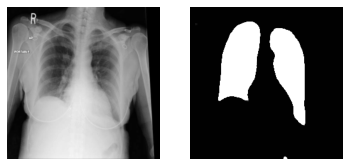


--- SUBJECT   1 ---


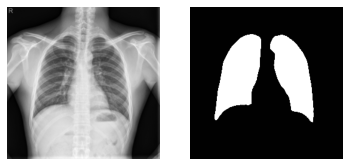


--- SUBJECT   2 ---


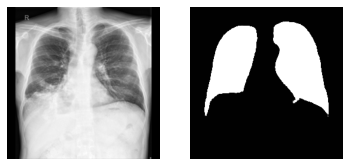


--- SUBJECT   3 ---


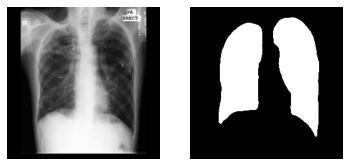


--- SUBJECT   4 ---


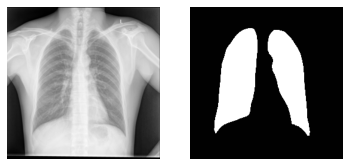


--- SUBJECT   5 ---


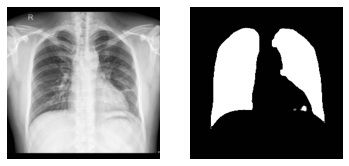


--- SUBJECT   6 ---


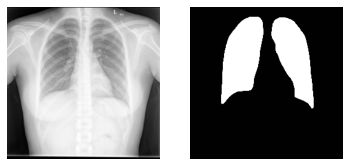


--- SUBJECT   7 ---


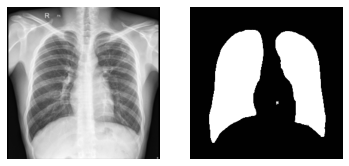


--- SUBJECT   8 ---


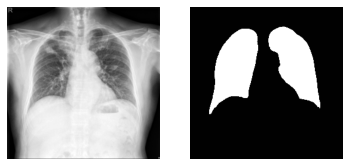


--- SUBJECT   9 ---


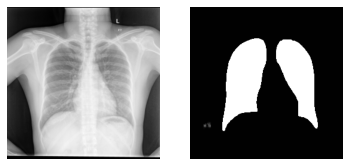


--- SUBJECT  10 ---


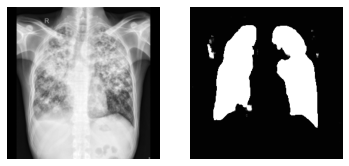


--- SUBJECT  11 ---


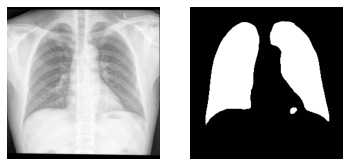


--- SUBJECT  12 ---


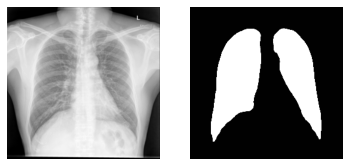


--- SUBJECT  13 ---


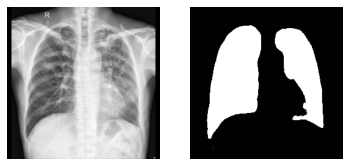


--- SUBJECT  14 ---


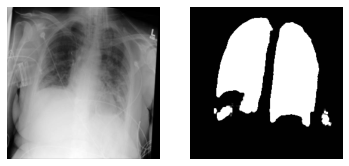


--- SUBJECT  15 ---


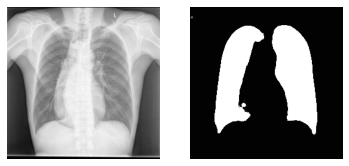


--- SUBJECT  16 ---


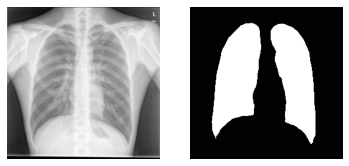


--- SUBJECT  17 ---


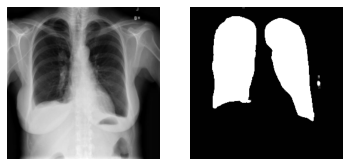


--- SUBJECT  18 ---


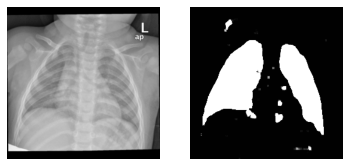


--- SUBJECT  19 ---


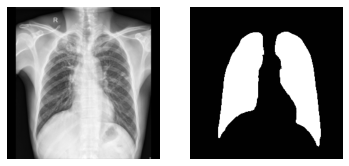


--- SUBJECT  20 ---


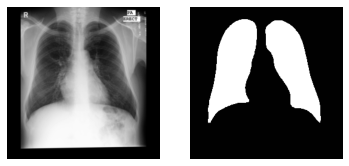


--- SUBJECT  21 ---


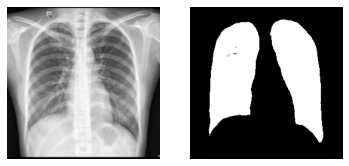


--- SUBJECT  22 ---


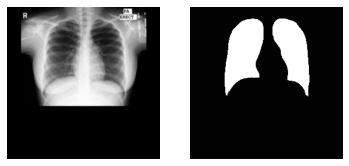


--- SUBJECT  23 ---


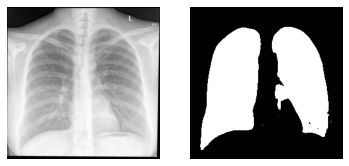


--- SUBJECT  24 ---


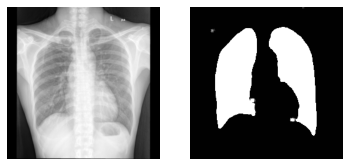


--- SUBJECT  25 ---


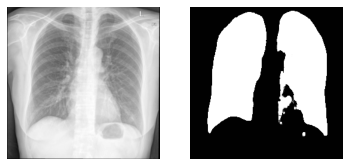


--- SUBJECT  26 ---


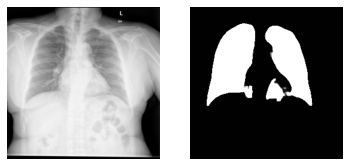


--- SUBJECT  27 ---


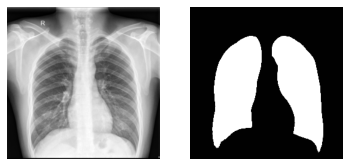


--- SUBJECT  28 ---


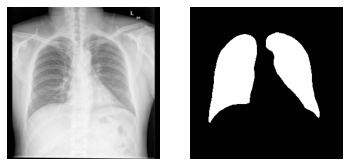


--- SUBJECT  29 ---


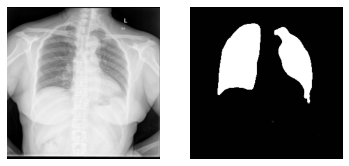


--- SUBJECT  30 ---


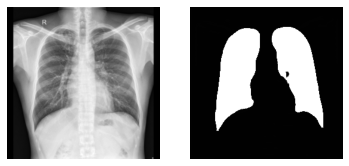


--- SUBJECT  31 ---


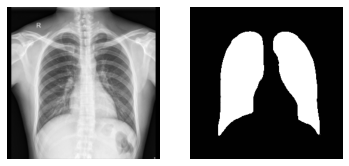


--- SUBJECT  32 ---


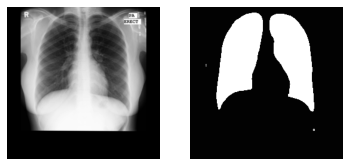


--- SUBJECT  33 ---


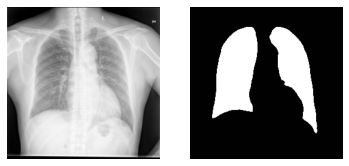

In [10]:
# load a trained model
model = load_model(last_save)

# Evaluate it on the test set
print("\n\n===== EVALUATION METRICS =====")
evaluate_model(dataset_test, model)

# Or... put dataset through a model and get predicted images
print("\n\n===== DATASET PREDICTION =====")
predicted_images = predict_dataset(dataset_test, model)
print(f"{np.shape(predicted_images)[0]} images predicted!")

# Or... put a single image through the model and plot the prediction
print("\n\n====== IMAGE PREDICTION ======")
for i in range(np.shape(dataset_test)[1] // 5):  # 1/5 of the test set displayed
    print(f"\n--- SUBJECT {i:3d} ---")
    predict_and_plot_image(dataset_test[0][i], model)